# Instacart Analysis Reccomendation Engine Project (Kaggle)

## Business Question: Which customers will be likely to buy again? How big will their orders be?

### Imports and initial view of Data

In [2]:
import pandas as pd #pandas library for dataframe manipulation
import numpy as np #algebra
import matplotlib.pyplot as plt #plotting graphs
%matplotlib inline
import seaborn as sns

Reading in the csv files into variables:

(Had to officially move over to Python 3 64 bit distribution due to memory errors from 32 bit version of Python 2.7+).

In [3]:
aisles = pd.read_csv('C:\\Users\\kj.park\\Desktop\Class\\Instacart\\aisles.csv')
order_products_prior = pd.read_csv("C:\\Users\\kj.park\\Desktop\\Class\\Instacart\\order_products__prior.csv")
orders = pd.read_csv("C:\\Users\\kj.park\\Desktop\\Class\\Instacart\\orders.csv")
products = pd.read_csv("C:\\Users\\kj.park\Desktop\\Class\\Instacart\\products.csv")
order_products_train = pd.read_csv("C:\\Users\\kj.park\\Desktop\\Class\\Instacart\\order_products__train.csv")
departments = pd.read_csv("C:\\Users\\kj.park\\Desktop\\Class\\Instacart\\departments.csv")

Created a for loop to print out the shapes of all of the variables to check out the composition of the datasets and one below it to check out the distinct column names

In [4]:
var_list = [aisles, order_products_prior, orders, products, order_products_train, departments]
name_list = ['aisles', 'order_products_prior', 'orders', 'products', 'order_products_train', 'departments']
count = 0
for var in var_list:
    print(name_list[count],":", var.shape)
    count += 1

aisles : (134, 2)
order_products_prior : (32434489, 4)
orders : (3421083, 7)
products : (49688, 4)
order_products_train : (1384617, 4)
departments : (21, 2)


In [5]:
var_list = [aisles, order_products_prior, orders, products, order_products_train, departments]
name_list = ['aisles', 'order_products_prior', 'orders', 'products', 'order_products_train', 'departments']
count = 0
for var in var_list:
    print(name_list[count],":", var.columns)
    count += 1

aisles : Index(['aisle_id', 'aisle'], dtype='object')
order_products_prior : Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')
orders : Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')
products : Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')
order_products_train : Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')
departments : Index(['department_id', 'department'], dtype='object')


#### It appears that our train and test files are the largest of the bunch.

- aisles:
    - It appears that there are 134 aisles to categorize the products available for purchase.
    - 2 distinct columns ['aisle_id','aisle']
- order_products_prior:
    - Historical data; largest filesize and the one dataframe variable that was causing the memory errors in the beginning of this project. 
    - 4 distinct columns ['order_id', 'product_id', 'add_to_cart_order','reordered'].
- orders:
    - Current orders
    - 7 distinct columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
- products:
    - The individual items a customer can buy from instacart.
    - 4 distinct columns: ['product_id','product_name', 'aisle_id','department_id']
- order_products_train:
    - The training dataset for the Machine Learning Algorithm/ Reccomendation Engine
    - 4 distinct columns: ['order__id','product_id','add_to_cart_order','reordered']; exactly the same as order_products_prior. This is the dataset that we will use to compare our outputs to the order_products_prior table

- departments:
    - Categorical type that clusters aisles into an overarching type
    - 2 distinct columns: ['department_id','department'] (mapping table)
    
    
From the tables and their makeup above, I will need to use pandas.merge() function to tie these tables by common key values.   

## From the fields listed above, there are a few interesting things that we can observe in our exploratory data analysis and this allows us to ask some more business questions:

1. What times do customers order most frequently?
2. What day of the week do people order the most?
3. How many products can we order 
4. What departments are most frequently ordered from?
5. What producsts are most requently ordered?

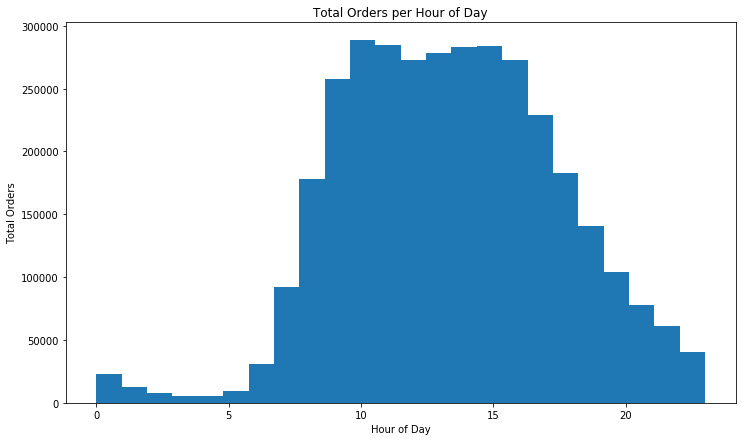

In [6]:
#Plotting histogram to see the most popular time of day the orders are made
plt.figure(figsize={12,7})
plt.hist(orders['order_hour_of_day'], bins = 24)
plt.title('Total Orders per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Orders')
plt.show()

Looks about standard for a workday and the order frequencies occur most during the standard work hours. Let's see at what frequency people order during each day:

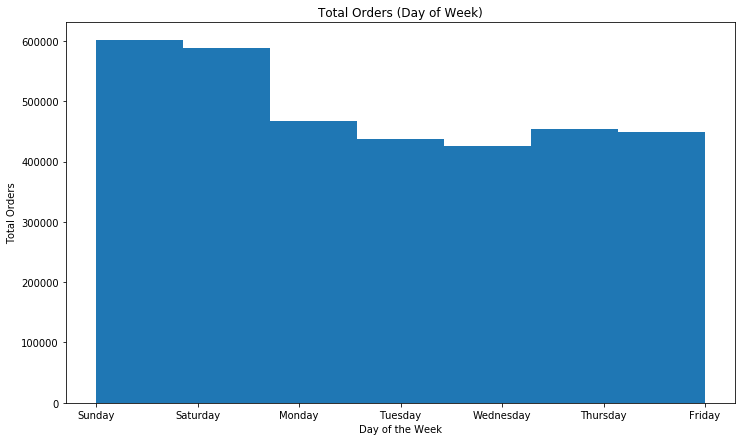

In [7]:
plt.figure(figsize={12,7})
plt.hist(orders['order_dow'], bins=7)
plt.ylabel('Total Orders')
plt.xlabel('Day of the Week')
plt.xticks(range(7), ("Sunday", "Saturday", "Monday","Tuesday", "Wednesday", "Thursday", "Friday"))
plt.title('Total Orders (Day of Week)')
 
plt.show()

It appears that most orders occur on the weekends. We can assume then that the most popular times to order are 10AM to 3PM while the most popular days to order are Sunday and Saturday. Ok, so what about returning customers and how long it takes them before coming back to order again? Let's do another histogram chart on the 'days_since_prior_order' field from the "orders" table:

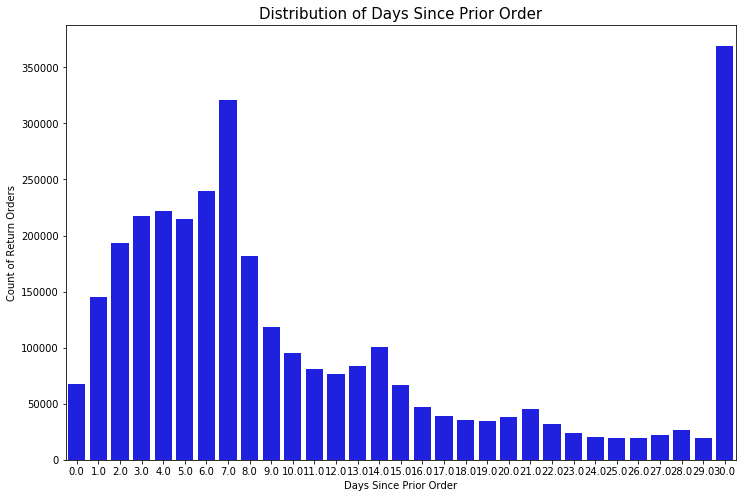

In [8]:
plt.figure(figsize=(12,8))
sns.countplot(x=orders['days_since_prior_order'], color='blue')
plt.ylabel('Count of Return Orders')
plt.xlabel('Days Since Prior Order')
plt.title('Distribution of Days Since Prior Order', fontsize = 15)
plt.xticks()
plt.show()


Customers tend to order once every week +- 1 day (with a peak at 7 days) or 30 or more days after. There also seems to be mini peaks around every 7 days after the first 7 (14 days after, 21 days after, and 28 days after).

Joining together all reference tables to order_products_prior for analysis and prepping the data to include all details.

In [9]:
#Doing left joins to catch all null values
prior_orders =  pd.merge(order_products_prior, products, how='left')
prior_orders = pd.merge(prior_orders, aisles, how = 'left')
prior_orders = pd.merge(prior_orders, departments, how = 'left')
prior_orders = pd.merge(prior_orders, orders, how = 'left')
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [10]:
#Looking at how many rows there are for each column value
total_rows = prior_orders.count()
print(total_rows)

order_id                  32434489
product_id                32434489
add_to_cart_order         32434489
reordered                 32434489
product_name              32434489
aisle_id                  32434489
department_id             32434489
aisle                     32434489
department                32434489
user_id                   32434489
eval_set                  32434489
order_number              32434489
order_dow                 32434489
order_hour_of_day         32434489
days_since_prior_order    30356421
dtype: int64


There are some people who choose to not be return customers (one time purchases)

In [11]:
#Looking at how many people re-order
reorder_rate = (len(order_products_prior[order_products_prior['reordered'] == 1]) / len(order_products_prior['reordered']))
                                 
print("Reorder Rate: " + str(reorder_rate))

Reorder Rate: 0.5896974667922161


59% Reorder Rate. Granted these could be first time customers

Products Ordered most often or Best Selling Products:

In [12]:
best_selling = order_products_train.groupby('product_id')
best_selling_count = best_selling['product_id'].count()
best_selling_count = best_selling_count.reset_index(name='count').sort_values(['count'], ascending=False)
best_selling = best_selling.head(11)
best_sellers = pd.merge(best_selling, products, on = 'product_id', how = 'inner', sort = False)
best_sellers.head(11)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16
5,2445303,49302,2,1,Bulgarian Yogurt,120,16
6,2853065,49302,12,1,Bulgarian Yogurt,120,16
7,3231517,49302,6,1,Bulgarian Yogurt,120,16
8,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
9,68474,11109,8,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16


In [13]:
prior_orders.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


Let's look at Aisle Distribution to see which aisles customers frequent most often.

In [14]:
plt.figure(figsize=(10,10))
temp_series = prior_orders['product_name'].value_counts(20)
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Aisle Distribution", fontsize=15)
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(100,100))
temp_series = prior_orders['aisle'].value_counts(20)
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Aisles", fontsize=15)
plt.show()



Looks like all of the largest slices of the pie are food related aisles. When we look at departments, this will be reflected under departments like "produce", "snacks", and "beverages." Let us see below:

In [ ]:
#pie chart to see the distrbution of what products are ordered from which department the most
plt.figure(figsize=(10,10))
temp_series = prior_orders['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments", fontsize=15)
plt.show()

From this we can see that produce (29.2%), dairy eggs (16.7%), snacks (8.9%), and beverages (8.3%) are the most prolific departments. People shop groceries more often than buy things like household supplies, personal care, and alcohol. This would also mean that instacart is definitely more of a grocery supplier than they are a supplier of other material goods.